In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc
import warnings
warnings.filterwarnings("ignore")

# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


59

In [ ]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [ ]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 384
skip = 384

for person in range(5,6):
  print('Person No.' + str(person))
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<5] = 0
  label[label>=5] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(40):
    sig = eeg[i][:32, :]
    sig = baseline_remove(sig)
    # Segmenting into 3 seconds (384 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += skip 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,32,384,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.5
(800, 32, 384, 1)
(800,) (320,) (480,)
(800,) (420,) (380,)


0

# **Proposed Architecture**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def LSTM_block(x):
  '''x = Bidirectional(LSTM(32, activation='selu', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
                           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None, 
                           dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True, go_backwards=True))(x)
  x = Bidirectional(LSTM(32, activation='selu', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
                           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None, 
                           dropout=0.2, recurrent_dropout=0.2, return_state=True, go_backwards=True))(x)'''
  x = Bidirectional(LSTM(16, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
                         recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                         bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None, 
                         dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True, go_backwards=True, name='LSTM_1'))(x)
  x = Bidirectional(LSTM(16, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
                         recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                         bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None, 
                         dropout=0.2, recurrent_dropout=0.2, go_backwards=True, name='LSTM_2'))(x)
  x = Reshape((x.shape[1], 1))(x)
  return x

def dilation_1DCNN_block(x, dilation_rate):
  initializer = tf.keras.initializers.LecunNormal()
  y = Conv1D(filters=8, kernel_size=7, strides=1, padding='causal', dilation_rate=dilation_rate, activation='selu', 
             kernel_initializer=initializer)(x)
  y = Conv1D(filters=8, kernel_size=7, strides=1, padding='causal', dilation_rate=dilation_rate, activation='selu', 
             kernel_initializer=initializer)(y)
  return y

def causal_dilation_1DCNN_block(x):
  initializer = tf.keras.initializers.LecunNormal()
  x = LSTM_block(x)
  x = Conv1D(filters=8, kernel_size=11, strides=1, padding='causal', dilation_rate=1, activation='selu', 
             kernel_initializer=initializer)(x)
  y1 = dilation_1DCNN_block(x, 1)
  x = MaxPool1D(pool_size=2)(x)
  y1 = MaxPool1D(pool_size=2)(y1)
  y2 = dilation_1DCNN_block(Add()([x, y1]), 2)
  y3 = dilation_1DCNN_block(Add()([y1, y2]), 4)
  y4 = dilation_1DCNN_block(Add()([y2, y3]), 8)
  x = Add()([y1, y2, y3, y4])
  x = MaxPool1D(pool_size=2)(x)
  x = Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', dilation_rate=1, activation='selu', 
             kernel_initializer=initializer)(x)
  x = MaxPool1D(pool_size=2)(x)
  x = Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', dilation_rate=1, activation='tanh', 
             kernel_initializer=initializer)(x)
  x = Dropout(0.1)(x)
  x = MaxPool1D(pool_size=2)(x)
  x = Flatten()(x)
  return x

def channel_wise_attention(x):
  x1 = causal_dilation_1DCNN_block(x[:,0,:,:])
  x2 = causal_dilation_1DCNN_block(x[:,1,:,:])
  x1 = Concatenate()([x1, x2])
  for i in range(2, x.shape[1]):
    x2 = causal_dilation_1DCNN_block(x[:,i,:,:])
    x1 = Concatenate()([x1, x2])
  x = Reshape((x.shape[1], x2.shape[1], 1))(x1)
  y = AvgPool2D(pool_size=(1,x.shape[2]), name='AvgPool2D_1')(x)
  y = Flatten(name='Flatten_1')(y)
  y = Dense(5,activation='tanh', name='Dense_1') (y)
  y = Dense(32,activation='softmax', name='Dense_2') (y)
  x = Multiply(name='Multiply_1')([x, tf.expand_dims(tf.expand_dims(y, axis=2), axis=2)])
  return x

def CNN_LSTM_Self_Attention(x):
  x = Conv2D(filters = 32, kernel_size = (32, 16), strides = (1, 1), padding = 'valid', name = 'Conv2D_1')(x)
  x = BatchNormalization(name='BatchNormalization_1')(x)
  x = Activation('elu', name = 'Activation_1')(x)
  x = MaxPool2D(pool_size=(1, x.shape[2]), name='MaxPool2D_1')(x)
  x = Reshape((1, x.shape[1]*x.shape[2]*x.shape[3]), name='Reshape_1')(x)
  '''x = LSTM(32, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None, 
           dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True, go_backwards=True, name='LSTM_1')(x)
  x = LSTM(32, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None, 
           dropout=0.2, recurrent_dropout=0.2, return_sequences=True, go_backwards=True, name='LSTM_2')(x)'''
  y = MultiHeadAttention(num_heads=8, key_dim=8, name = 'MultiHeadAttention_1')(x, x)
  y = Activation('softmax', name = 'Activation_2')(y)
  x = Multiply(name='Multiply_2')([x, y])
  x = Flatten(name='Flatten_2')(x)
  #x = Dense(32, activation='relu', name='Dense_3') (x)
  x = Dense(2, activation='softmax', name='Dense_4') (x)
  return x


In [ ]:
def get_model() :
  input_shape = (data.shape[1], data.shape[2],1)
  a = Input(input_shape)
  out = causal_dilation_1DCNN_block(a[:, 0, :, :])
  #out = LSTM_block(a[:, 0, :, :])
  model = Model(a, out)
  return model

model = get_model()
model.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 32, 384, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.__operators__.getitem_749 (  (None, 384, 1)      0           ['input_13[0][0]']               
 SlicingOpLambda)                                                                                 
                                                                                                  
 bidirectional_410 (Bidirection  [(None, 384, 32),   2304        ['tf.__operators__.getitem_749[0]
 al)                             (None, 16),                     [0]']                     

In [ ]:
def get_model() :
  input_shape = (data.shape[1], data.shape[2],1)
  a = Input(input_shape, name='Input')
  out = channel_wise_attention(a)
  out = CNN_LSTM_Self_Attention(out)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=1e-4)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model
model = get_model()
print(model.summary())

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 32, 384, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.__operators__.getitem_750 (  (None, 384, 1)      0           ['Input[0][0]']                  
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_751 (  (None, 384, 1)      0           ['Input[0][0]']                  
 SlicingOpLambda)                                                                          

In [ ]:
batch_size = 10
epochs = 100
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

265106

In [ ]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(720, 32, 384, 1) (80, 32, 384, 1) (720, 2) (80, 2)


In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/100
 8/65 [==>...........................] - ETA: 7:10:35 - loss: 1.8236 - accuracy: 0.3750

In [ ]:
acc = model.evaluate(x_test, y_test)
print(acc)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
print(f1scr)
cnfsn = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print(cnfsn)

3/3 [==============================] - 0s 96ms/step - loss: 1.0347 - accuracy: 0.6875
[1.0347198247909546, 0.6875]
0.6834942237695838
[[23  4]
 [21 32]]


Accuracy  : 0.8949999988079071
F1_Score  : 0.8813415472418142


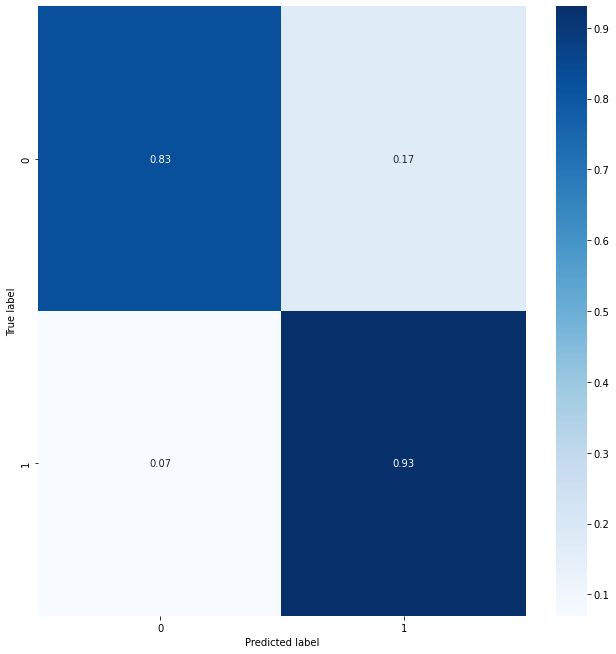

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(720, 32, 384, 1) (80, 32, 384, 1) (720, 2) (80, 2)


In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/100
65/65 [==============================] - 7s 31ms/step - loss: 0.8509 - accuracy: 0.4815 - val_loss: 0.8401 - val_accuracy: 0.5972
Epoch 2/100
65/65 [==============================] - 1s 22ms/step - loss: 0.8307 - accuracy: 0.4907 - val_loss: 0.8211 - val_accuracy: 0.5972
Epoch 3/100
65/65 [==============================] - 1s 22ms/step - loss: 0.8126 - accuracy: 0.6312 - val_loss: 0.8037 - val_accuracy: 0.6389
Epoch 4/100
65/65 [==============================] - 1s 21ms/step - loss: 0.7967 - accuracy: 0.5926 - val_loss: 0.7887 - val_accuracy: 0.6389
Epoch 5/100
65/65 [==============================] - 1s 21ms/step - loss: 0.7810 - accuracy: 0.6806 - val_loss: 0.7743 - val_accuracy: 0.6250
Epoch 6/100
65/65 [==============================] - 1s 20ms/step - loss: 0.7643 - accuracy: 0.6836 - val_loss: 0.7599 - val_accuracy: 0.5694
Epoch 7/100
65/65 [==============================] - 1s 22ms/step - loss: 0.7358 - accuracy: 0.6852 - val_loss: 0.7353 - val_accu

Accuracy  : 0.8475000023841858
F1_Score  : 0.8405932998814845


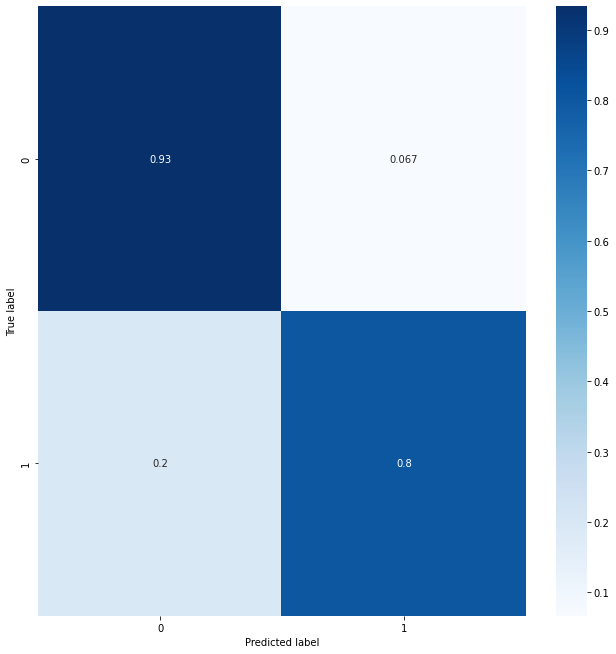

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()